# Homework3 Convex Optimization Problems

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## "Hello World" in CVX
minimize $f_0(x_1, x_2)$  
subject to $2x_1 + x_2 \geq 1$, $x_1 + 3x_2 \geq 1$, $x_1 \geq 0$, $x_2 \geq 0$

when $f_0(x_1, x_2)=x_1 + x_2$

In [2]:
x = cp.Variable(2)
obj = cp.Minimize(x[0] + x[1])
constraints = [x >= 0, 2 * x[0] + x[1] >= 1, x[0] + 3 * x[1] >= 1]

prob = cp.Problem(objective=obj, constraints=constraints)
prob.solve()

print("optimal value is %.4f" % prob.value)
print("x is ", x.value)

optimal value is 0.6000
x is  [0.4 0.2]


when $f_0(x_1, x_2) = x_1^2 + 9x_2^2$

In [3]:
obj = cp.Minimize(x[0] ** 2 + 9 * x[1] ** 2)
prob = cp.Problem(objective = obj, constraints = constraints)
prob.solve()

print("optimal value is %.4f" % prob.value)
print("x is ", x.value)

optimal value is 0.5000
x is  [0.5        0.16666667]


## Heuristic suboptimal solution for Boolean LP

### relaxed LP
minimize $c^Tx$  
subject to $Ax \leq b$, $0 \leq x \leq 1$

In [4]:
n = 100
m = 300
A = np.random.random(size=(m, n))
b = A @ np.ones(shape=(n, )) / 2
c = -np.random.random(size=(n, 1))

x_rlx = cp.Variable(n)
obj = cp.Minimize(c.T @ x_rlx)
cst = [0 <= x_rlx, x_rlx <= 1, A @ x_rlx <= b]

prob = cp.Problem(objective=obj, constraints=cst)
prob.solve()

print("optimal value: ", prob.value)

optimal value:  -35.185950030524886


In [5]:
opt_val = 100
t_vals = np.linspace(0, 1, 100)
vals, thres = [], []
for t in t_vals:
    x = (x_rlx.value >= t).astype(int)
    if np.max(A @ x - b) <= 0:
        thres.append(t)
        curr_val = c.T @ x
        opt_val = min(curr_val, opt_val)
        vals.append(curr_val)
print("optimal value: ", opt_val)
print("upper bound - lower bound = ", opt_val - prob.value)

optimal value:  [-33.84484691]
upper bound - lower bound =  [1.34110312]


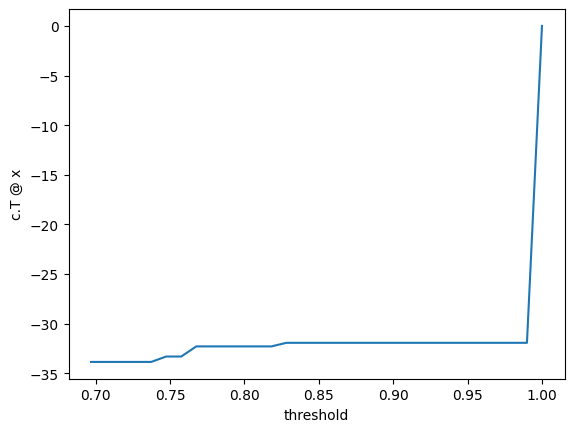

In [6]:
plt.plot(thres, vals, )
plt.xlabel('threshold')
plt.ylabel('c.T @ x')
plt.show()
plt.close()

## Simple portfolio optimization

In [7]:
n = 20
pbar = np.ones(shape=(n,)) * .03 + \
        .12 * np.concatenate((np.random.random((n - 1,)), np.array([0])), axis=0)
S = np.random.randn(n, n)
S = S.T @ S
S = S / max(abs(np.diag(S))) * .2

S[:, n-1] = 0
S[n-1, :] = 0

x_unif = np.ones((n,)) / n

In [8]:
expected = pbar.T @ x_unif
print("expected return is ", expected)
print("risk on uniform portfolio is ", x_unif.T @ S @ x_unif)

expected return is  0.08665969137904908
risk on uniform portfolio is  0.0035096648492225786


the risk of an optimal portfolio with no (additional) constraints

In [9]:
x = cp.Variable(n)
cst1 = [cp.sum(x) == 1, pbar.T @ x == expected]
obj = cp.Minimize(cp.quad_form(x, S))
prob1 = cp.Problem(obj, cst1)
prob1.solve()

print(prob1.value)

0.0007360049148923248


the risk of a **long-only** portfolio $x \geq 0$

In [10]:
cst2 = cst1 + [x >= 0]
prob2 = cp.Problem(obj, cst2)
prob2.solve()

print(prob2.value)

0.0013220473425327808


the risk of a portfolio with a **limit on total short position**  
$1^T(x_-) \leq 0.5$, $(x_-)_i = max\{-x_i, 0\}$

In [11]:
cst3 = cst1 + [cp.sum(cp.pos(-x)) <= 0.5]
prob3 = cp.Problem(obj, cst3)
prob3.solve()

print(prob3.status)
print(prob3.value)

optimal
0.0008041998969535468


Plot the optimal trade-off curve for the **long-only** portfolio and for **total short-position limited to 0.5**

In [12]:
x = cp.Variable(n)
gamma_vals = np.logspace(-4, 6, 200)
gamma = cp.Parameter(nonneg=True)
obj = cp.Maximize(pbar.T @ x - gamma * cp.quad_form(x, S))
prob1 = cp.Problem(obj, [cp.sum(x) == 1, x >= 0])
prob2 = cp.Problem(obj, [cp.sum(x) == 1, cp.sum(cp.pos(-x)) <= 0.5])

dev1, mean1 = [], []
dev2, mean2 = [], []
for g in gamma_vals:
    gamma.value = g
    # long-only
    prob1.solve()
    dev1.append(x.value.T @ S @ x.value)
    mean1.append(pbar.T @ x.value)
    # short-position limit
    prob2.solve()
    dev2.append(x.value.T @ S @ x.value)
    mean2.append(pbar.T @ x.value)

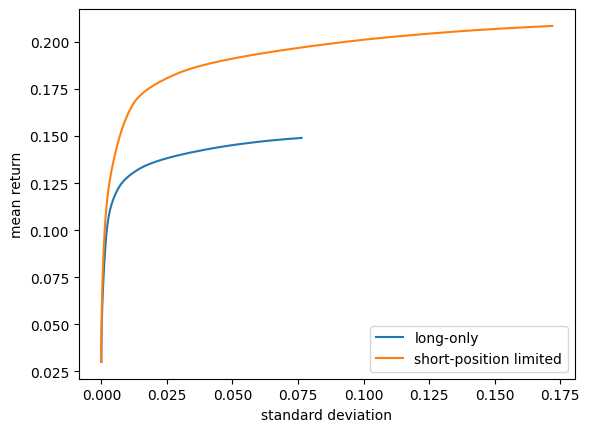

In [13]:
plt.plot(dev1, mean1, dev2, mean2)
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.legend(['long-only', 'short-position limited'])
plt.show()